In [32]:
# for database and dataframe
import sqlite3
import pandas as pd

# for plotting and processing
from tqdm import tqdm
import matplotlib.pyplot as plt

# own functions (database, approximation, etc)
import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# For ML part
import torch
import numpy as np
print("GPU connected: ", torch.cuda.is_available())
torch.cuda.empty_cache()

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if  torch.backends.mps.is_available() else 'cpu')

GPU connected:  True


In [34]:
if torch.cuda.is_available():
    # select available GPU
    print("GPU connected: ", torch.cuda.current_device())

GPU connected:  0


# Load dataframe from database

In [35]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1009 # random seed 
}

In [36]:
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
# # abort if interpolation exists already
# if exists_in_database(con, cur, 'beta_interpolations', params):
#     raise ValueError("Interpolation already exists for chosen parameters.")
simulations= pd.read_sql_query("SELECT * from simulations", con)
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()

In [37]:
# select simulations with the specified parameters
simulations = simulations[(simulations['N'] == params['N']) & (simulations['K'] == params['K']) & (simulations['mu'] == params['mu']) & (simulations['seed'] == params['seed'])]
# only windows larger equal 1
simulations = simulations[simulations['window'] >= 1]
# number of simulations
print("Number of simulations: ", len(simulations))
# drop constant columns
simulations = simulations.drop(columns=['seed', 'N', 'K', 'mu'])
# simulation_id is the unique identifier for each simulation and identifyer in beta_approximations
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]
print("Number of simulations with fit parameters: ", len(simulations))
simulations.head()


Number of simulations:  2975
Number of simulations with fit parameters:  2975


,simulation_id,lambda,h,window,raw_file,dataset
21452,21453,0.982217,3.162278e-07,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0
21453,21454,0.982217,3.162278e-07,10.0,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0
21454,21455,0.982217,3.162278e-07,100.0,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0
21455,21456,0.982217,3.162278e-07,1000.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0
21456,21457,0.982217,3.162278e-07,10000.0,/scratch02.local/johannes/projects/sahel_finit...,samples/10000.0


In [38]:
# merge the two dataframes according to simulation_id (which only keeps the ones where analysis was done so far!!)
df = pd.merge(simulations, beta_approximations, on='simulation_id')
df

,simulation_id,lambda,h,window,raw_file,dataset,a,b,loc,scale
0,21453,0.982217,3.162278e-07,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,10.853718,103690.590339,-0.0001,1.0002
1,21454,0.982217,3.162278e-07,10.0,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,11.353166,108462.810849,-0.0001,1.0002
2,21455,0.982217,3.162278e-07,100.0,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,14.093276,134643.858577,-0.0001,1.0002
3,21456,0.982217,3.162278e-07,1000.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,23.776416,227160.615266,-0.0001,1.0002
4,21457,0.982217,3.162278e-07,10000.0,/scratch02.local/johannes/projects/sahel_finit...,samples/10000.0,42.893363,409652.454000,-0.0001,1.0002
...,...,...,...,...,...,...,...,...,...,...
2970,30273,0.999000,1.000000e-02,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,41.686637,20.755306,-0.0001,1.0002
2971,30274,0.999000,3.162278e+01,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,4329.953184,17.793955,-0.0001,1.0002
2972,30275,0.999438,5.623413e-04,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,2.165585,10.805671,-0.0001,1.0002
2973,30276,0.999438,1.778279e+00,1.0,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,3580.448384,10.475123,-0.0001,1.0002


Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

DenseNN(
  (act): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=60, bias=True)
    (1-2): 2 x Linear(in_features=60, out_features=60, bias=True)
  )
  (output): Linear(in_features=60, out_features=2, bias=True)
)
Next steps:
>> func.set_map() # optimize parameter distribution over activation function domain (input) and range (output) 
>> func.train() # train neural network model
>> func.save(filename) # save function approximation to file
Device for training: cuda
Training data with input shape torch.Size([2975, 3]) and output shape torch.Size([2975, 2]).


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Training: 100%|██████████| 30000/30000 [02:05<00:00, 239.66it/s]


Training complete; left training mode for faster evaluation! To re-enter training mode call `func.model.train(True)`.


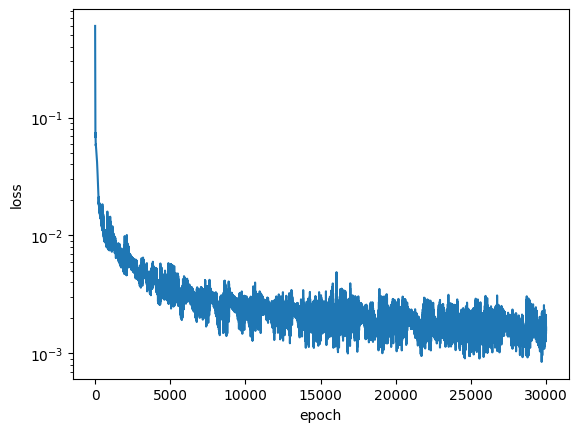

In [40]:
# initialize function approximation
params_func = params.copy()
# check that loc and scale are unique and pass them to the function as constant. Abort if this is violated because then it would need to be fitted!
if len(df['loc'].unique()) != 1:
    raise ValueError("loc is not unique!")
if len(df['scale'].unique()) != 1:
    raise ValueError("scale is not unique!")
params_func['loc'] = df['loc'].unique()[0] 
params_func['scale'] = df['scale'].unique()[0]
func = FunctionApproximation(
    verbose=True, input=['lambda', 'window', 'h'],
    output=['a', 'b'], 
    params=params_func, 
    model = DenseNN(
                input_size=3,
                hidden_sizes=[60, 60, 60],
                output_size=2,
            )
)
# specify a map from input to NN (inverse not needed)
func.set_map_to_NN('lambda', lambda x: np.log10(1-x))
func.set_map_to_NN('window', lambda x: np.log10(x))
func.set_map_to_NN('h',      lambda x: np.log10(x))
# specify a map from output to NN (for training)
func.set_map_to_NN('a', lambda y: np.log10(y))
func.set_map_to_NN('b', lambda y: np.log10(y))
# specify a map from NN to output (for application)
func.set_map_from_NN('a', lambda Y: 10**Y)
func.set_map_from_NN('b', lambda Y: 10**Y)
# custom loss function (torch functions only)
X = df[['lambda', 'window', 'h']].values
theory = mean_field_activity(X[:,0], params['mu'], X[:,2])
theory = torch.from_numpy(theory).float().to(device)
# TODO: prepare data to have access to all these scalings
Xs, Ys, = func.prepare_data(df)
min_Y = torch.from_numpy(func.Y_scaler.min_).float().to(device)
scale_Y = torch.from_numpy(func.Y_scaler.scale_).float().to(device)
def custom_loss(Y_pred, Y, X):
    # standard loss
    std_loss = nn.MSELoss(reduction="mean")
    loss = std_loss(Y_pred,Y)
    # add analytical knowledge of function for mean (not working because in order to use MinMaxScaler we need to be on the CPU...why?)
    # undo scaler
    y = (Y_pred - min_Y)/(scale_Y)
    # compare activity (a/(a+b)) to theory
    loga,logb = y[:,0], y[:,1]
    a = torch.pow(10, loga)
    b = torch.pow(10, logb)
    pred = a/(a+b)
    loss += torch.mean(torch.abs(pred - theory))
    return loss
# training (takes care of mapping and scaling input and output)
loss = func.train(Xs, Ys, epochs=30000, device=device, custom_loss=custom_loss, lr=0.001)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

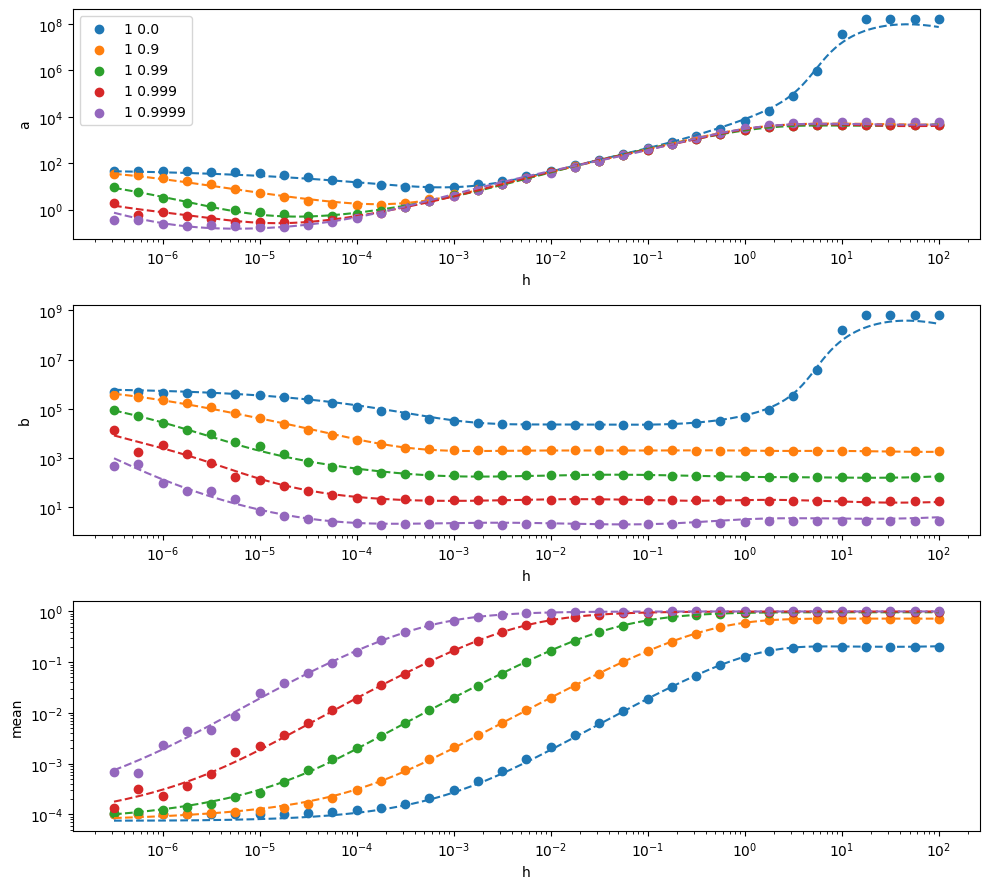

In [41]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# mesh grid for approximation
hvals = 10**np.linspace(-6.5, 2, 200)

windows = df["window"].unique()
lambdas = np.sort(df["lambda"].unique())
hs = df["h"].unique()

window = 1
for lam in lambdas[::4]:
    # load data
    df_temp = df[(df["window"] == window) & (df["lambda"] == lam)]

    # get a,b from function approximation
    avals, bvals = func(lam * np.ones_like(hvals), window * np.ones_like(hvals), hvals)

    ref = axes[0].scatter(
        df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam)
    )
    axes[0].plot(hvals, avals, color=ref.get_facecolor()[0], linestyle="--")
    axes[1].scatter(
        df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam)
    )
    axes[1].plot(hvals, bvals, color=ref.get_facecolor()[0], linestyle="--")
    axes[2].scatter(
        df_temp["h"].values,
        df_temp["a"] / (df_temp["a"] + df_temp["b"] ),
        label="{} {}".format(window, lam),
    )
    axes[2].plot(hvals,  avals/ (avals+bvals), color=ref.get_facecolor()[0], linestyle="--")

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("mean")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].legend(loc="upper left")
plt.tight_layout()

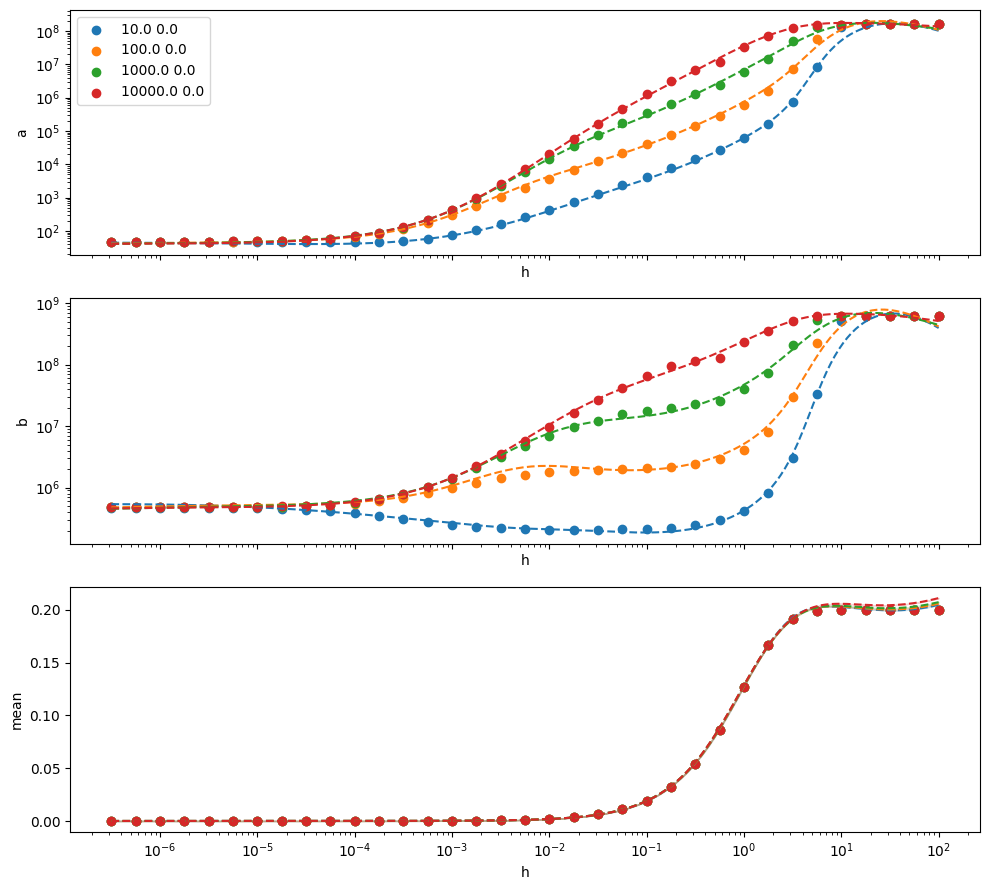

In [42]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# mesh grid for approximation
hvals = 10**np.linspace(-6.5, 2, 200)

windows = df["window"].unique()
lambdas = np.sort(df["lambda"].unique())
hs = df["h"].unique()

lam=0.0
for window in sorted(windows)[1:]:
    # load data
    df_temp = df[(df["window"] == window) & (df["lambda"] == lam)]

    # get a,b from function approximation
    avals, bvals = func(lam * np.ones_like(hvals), window * np.ones_like(hvals), hvals)

    ref = axes[0].scatter(
        df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam)
    )
    axes[0].plot(hvals, avals, color=ref.get_facecolor()[0], linestyle="--")
    axes[1].scatter(
        df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam)
    )
    axes[1].plot(hvals, bvals, color=ref.get_facecolor()[0], linestyle="--")
    axes[2].scatter(
        df_temp["h"].values,
        df_temp["a"] / (df_temp["a"] + df_temp["b"] ),
        label="{} {}".format(window, lam),
    )
    axes[2].plot(hvals,  avals/ (avals+bvals), color=ref.get_facecolor()[0], linestyle="--")
    # plot percentiles
    beta = stats.beta(avals, bvals)
    percentile_25 = beta.ppf(0.25)
    percentile_75 = beta.ppf(0.75)
    axes[2].fill_between(hvals, percentile_25, percentile_75, color=ref.get_facecolor()[0], alpha=0.2)


axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("mean")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
# axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].legend(loc="upper left")
plt.tight_layout()

### Save function approximation to file

In [43]:
# filename that includes parameters
filename = f'./dat/beta_interpolation_N={params["N"]}_K={params["K"]}_mu={params["mu"]}_seed={params["seed"]}.pkl'
func.save(filename=filename)

params['filename'] = filename

# store in database
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
insert_into_database(con, cur, 'beta_interpolations', params)
con.commit()
con.close()

In [44]:
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
interpolations = pd.read_sql_query("SELECT * from beta_interpolations", con)
con.close()
interpolations

,N,K,mu,seed,filename
0,10000,100,0.2,1001,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
1,10000,100,0.2,1000,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
2,10000,100,0.2,1002,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
3,10000,100,0.2,1003,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
4,10000,100,0.2,1004,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
5,10000,100,0.2,1005,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
6,10000,100,0.2,1006,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
7,10000,100,0.2,1008,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...
8,10000,100,0.2,1009,./dat/beta_interpolation_N=10000_K=100_mu=0.2_...


In [45]:
#test
print(func(0.9,1,1e-3))
test = FunctionApproximation(filename=filename)
print(test(0.9,1,1e-3))

(4.043793, 1985.6799)
(4.043793, 1985.6799)


In [46]:
# disconnect from device
torch.cuda.empty_cache()
print("GPU connected: ", torch.cuda.is_available())
print('Memory Usage:', torch.cuda.memory_allocated() / 1024 ** 2, 'MB')


GPU connected:  True
Memory Usage: 16.2626953125 MB
